## Hyperparameter Tuning
This notebook shows methods used to HP Tune the models.

A random search found a good paramter 'area' to search within. The Optuna package was used to obtain the config for the model(s).

In [2]:
import os
import random

import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision import transforms

from time import time
from tqdm import tqdm

from src.model import ConvCount
import src.model as m
from src.data import SpectrogramDataset
from src.utils.helpers import *



dataset = SpectrogramDataset(csv_file=r"data/labels/final_labels.csv") 

#### Initial Model
The config is made with an 'educated guess' to start with

In [4]:
# Config
conv1_out = 8
conv2_out = 16
conv3_out = 32
conv4_out = 64
dropout_prob = 0.5
fc_hidden = 64



# init model
model = ConvCount(
    conv1_out = conv1_out,
    conv2_out = conv2_out,
    conv3_out = conv3_out,
    conv4_out= conv4_out,
    fc_hidden = fc_hidden,
    dropout_prob = dropout_prob
)



train_loader, val_loader = get_loaders(dataset)


# cpu or gpu; whichever is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



# basic loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



# Model training
for epoch in range(1):
    start_time = time()
    avg_loss = train_one_epoch(model, train_loader, optimizer, device)
    duration = time() - start_time
    print(f"Epoch {epoch+1} — Loss: {avg_loss:.4f} — Time: {duration:.2f}s")


# Validation
validate(model, val_loader, device)

Training: 100%|██████████| 2907/2907 [24:11<00:00,  2.00batch/s]


Epoch 1 — Loss: 0.7533 — Time: 1451.34s


0.6448228414172686

### Hyperparameter Tuning with Random Search

Starting with random search to find a 'general area' to search in

In [2]:
# Step 1: Stratified Sampling. Creates a balanced subset of the data for quick tuning
train_loader, val_loader = get_stratified_loaders(
    dataset,
    subset_frac=0.10,   # 10% subset
    train_frac=0.8,     
    batch_size=32,
    random_state=42,
    shuffle_train=True
)

NameError: name 'dataset' is not defined

In [5]:
# # Hyperparam search space for Random Search (RS)
# # RS works by randomly selecting a config, num_trials times. This gives a general idea of a good config without iterating through every possible config
param_space = {
    "lr": [1e-4, 1e-3, 1e-2],
    "dropout": [0.1, 0.3, 0.5],
    "fc_hidden": [64, 128, 256],
    "conv1_out": [8, 16, 32],
    "conv2_out": [16, 32, 64],
    "conv3_out": [32, 64, 128],
    "conv4_out": [32, 64, 128]
}

# RS is simple to implement with the random package
def sample_config():
    return {k: random.choice(v) for k, v in param_space.items()}

In [11]:
# 10 configs pulled randomly from param_space, each trained for 3 epochs
# This is possible in reasonable time because of the subset size
num_trials = 10
epochs = 3
results = []

for trial in range(1, num_trials + 1):
    config = sample_config()
    print(f"\n=== Trial {trial}/{num_trials} ===")
    print(f"Config: {config}")



    # Setting up the model with the current random config
    model = ConvCount(
        conv1_out=config["conv1_out"],
        conv2_out=config["conv2_out"],
        conv3_out=config["conv3_out"],
        conv4_out=config["conv4_out"],
        fc_hidden=config["fc_hidden"],
        dropout_prob=config["dropout"]
    ).to(device)



    optimizer = optim.Adam(model.parameters(), lr=config["lr"])



    # Cross entropy loss
    criterion = nn.CrossEntropyLoss()



    # Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        start = time()


        for xb, yb in tqdm(train_loader, desc=f"Trial {trial} — Epoch {epoch}", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


        # This is just verbose to inspect progress
        duration = time() - start
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch} — Loss: {avg_loss:.4f} — Time: {duration:.2f}s")



    acc = validate(model, val_loader, device)
    print(f"Validation Accuracy: {acc:.2%}")
    results.append((acc, config))



# Show top results
results.sort(reverse=True, key=lambda x: x[0])
print("\n=== Top Results ===")
for acc, cfg in results[:5]:
    print(f"Accuracy: {acc:.4f} | Config: {cfg}")


=== Trial 1/10 ===
Config: {'lr': 0.0001, 'dropout': 0.5, 'fc_hidden': 256, 'conv1_out': 8, 'conv2_out': 32, 'conv3_out': 32, 'conv4_out': 64}


Epoch 0 — Loss: 0.8971 — Time: 93.50s


Epoch 1 — Loss: 0.7915 — Time: 20.24s


Epoch 2 — Loss: 0.7785 — Time: 21.25s
Validation Accuracy: 60.28%

=== Trial 2/10 ===
Config: {'lr': 0.01, 'dropout': 0.5, 'fc_hidden': 64, 'conv1_out': 16, 'conv2_out': 32, 'conv3_out': 32, 'conv4_out': 64}


Epoch 0 — Loss: 0.9307 — Time: 25.87s


Epoch 1 — Loss: 0.8236 — Time: 27.03s


Epoch 2 — Loss: 0.8050 — Time: 27.03s
Validation Accuracy: 52.02%

=== Trial 3/10 ===
Config: {'lr': 0.01, 'dropout': 0.1, 'fc_hidden': 128, 'conv1_out': 16, 'conv2_out': 64, 'conv3_out': 128, 'conv4_out': 64}


Epoch 0 — Loss: 0.9758 — Time: 78.27s


Epoch 1 — Loss: 0.8074 — Time: 115.36s


Epoch 2 — Loss: 0.7953 — Time: 117.88s
Validation Accuracy: 60.79%

=== Trial 4/10 ===
Config: {'lr': 0.001, 'dropout': 0.1, 'fc_hidden': 256, 'conv1_out': 32, 'conv2_out': 64, 'conv3_out': 32, 'conv4_out': 32}


Epoch 0 — Loss: 0.8497 — Time: 122.88s


Epoch 1 — Loss: 0.7799 — Time: 121.00s


Epoch 2 — Loss: 0.7617 — Time: 119.88s
Validation Accuracy: 58.77%

=== Trial 5/10 ===
Config: {'lr': 0.0001, 'dropout': 0.3, 'fc_hidden': 128, 'conv1_out': 16, 'conv2_out': 32, 'conv3_out': 32, 'conv4_out': 64}


Epoch 0 — Loss: 0.8782 — Time: 70.21s


Epoch 1 — Loss: 0.7853 — Time: 70.36s


Epoch 2 — Loss: 0.7625 — Time: 70.91s
Validation Accuracy: 60.62%

=== Trial 6/10 ===
Config: {'lr': 0.001, 'dropout': 0.1, 'fc_hidden': 128, 'conv1_out': 8, 'conv2_out': 32, 'conv3_out': 128, 'conv4_out': 32}


Epoch 0 — Loss: 0.8466 — Time: 73.10s


Epoch 1 — Loss: 0.7717 — Time: 35.08s


Epoch 2 — Loss: 0.7529 — Time: 27.91s
Validation Accuracy: 60.88%

=== Trial 7/10 ===
Config: {'lr': 0.01, 'dropout': 0.3, 'fc_hidden': 128, 'conv1_out': 16, 'conv2_out': 32, 'conv3_out': 32, 'conv4_out': 32}


Epoch 0 — Loss: 0.9354 — Time: 27.53s


Epoch 1 — Loss: 0.8276 — Time: 26.89s


Epoch 2 — Loss: 0.8038 — Time: 28.52s
Validation Accuracy: 61.31%

=== Trial 8/10 ===
Config: {'lr': 0.001, 'dropout': 0.3, 'fc_hidden': 64, 'conv1_out': 32, 'conv2_out': 16, 'conv3_out': 128, 'conv4_out': 128}


Epoch 0 — Loss: 0.8481 — Time: 44.48s


Epoch 1 — Loss: 0.7747 — Time: 43.28s


Epoch 2 — Loss: 0.7570 — Time: 43.48s
Validation Accuracy: 60.45%

=== Trial 9/10 ===
Config: {'lr': 0.001, 'dropout': 0.3, 'fc_hidden': 64, 'conv1_out': 32, 'conv2_out': 64, 'conv3_out': 32, 'conv4_out': 128}


Epoch 0 — Loss: 0.8669 — Time: 48.66s


Epoch 1 — Loss: 0.7874 — Time: 48.69s


Epoch 2 — Loss: 0.7660 — Time: 109.79s
Validation Accuracy: 59.50%

=== Trial 10/10 ===
Config: {'lr': 0.01, 'dropout': 0.3, 'fc_hidden': 256, 'conv1_out': 8, 'conv2_out': 64, 'conv3_out': 32, 'conv4_out': 128}


Epoch 0 — Loss: 1.2562 — Time: 156.40s


Epoch 1 — Loss: 0.8423 — Time: 39.07s


Epoch 2 — Loss: 0.8271 — Time: 52.90s
Validation Accuracy: 59.03%

=== Top Results ===
Accuracy: 0.6131 | Config: {'lr': 0.01, 'dropout': 0.3, 'fc_hidden': 128, 'conv1_out': 16, 'conv2_out': 32, 'conv3_out': 32, 'conv4_out': 32}
Accuracy: 0.6088 | Config: {'lr': 0.001, 'dropout': 0.1, 'fc_hidden': 128, 'conv1_out': 8, 'conv2_out': 32, 'conv3_out': 128, 'conv4_out': 32}
Accuracy: 0.6079 | Config: {'lr': 0.01, 'dropout': 0.1, 'fc_hidden': 128, 'conv1_out': 16, 'conv2_out': 64, 'conv3_out': 128, 'conv4_out': 64}
Accuracy: 0.6062 | Config: {'lr': 0.0001, 'dropout': 0.3, 'fc_hidden': 128, 'conv1_out': 16, 'conv2_out': 32, 'conv3_out': 32, 'conv4_out': 64}
Accuracy: 0.6045 | Config: {'lr': 0.001, 'dropout': 0.3, 'fc_hidden': 64, 'conv1_out': 32, 'conv2_out': 16, 'conv3_out': 128, 'conv4_out': 128}


#### Interpreting the results
Some key takeaways from the random search:
- `lr` varies across the top 5. This will need investigating further.

- `dropout = 0.5` doesn't appear in the top 5 once.

- `fc_hidden = 128` is a very strong performer.

- `conv1_out` performs well at 8 and 16.

- `conv2_out` is strong at 32, but 64 is worth keeping.

- It turns out that `conv3_out = 64` wasn't selected at all in the random search, so it's hard to interpret.

- `conv4_out` appears strong at 32, but it's still important to try other values. For example, there are no runs where `fc_hidden = 128` and `conv4_out = 128`, so it's hard to say without further testing.



 With this information we can create a good grid for Optuna to work with.

#### Hyperparameter tuning with Successive‐Halving (SH) via Optuna
SH runs all models over one epoch and keeps models that perform above a pruning threshold. This repeats, reducing the model set each epoch, until a winner is clear.

The Optuna package was chosen because it caches model weights each epoch, hugely reducing compute. Additionally it uses continuous, asynchronous pruning rather than fixed-round halving, improving scalability and resource allocation.

In [6]:
import optuna

# After each epoch a model is compared to the current best; if there is no chance it will outperform the best model, it's pruned
def objective(trial):

    cfg = {
      'lr': trial.suggest_categorical('lr', [0.01,0.001,0.005]),
      'dropout_prob': trial.suggest_categorical('dropout_prob', [0.1,0.2,0.3]),
      'fc_hidden': 128,
      'conv1_out': trial.suggest_categorical('conv1_out',[8,16]),
      'conv2_out': trial.suggest_categorical('conv2_out',[32,64]),
      'conv3_out': trial.suggest_categorical('conv3_out',[32,64,128]),
      'conv4_out': trial.suggest_categorical('conv4_out',[32,64,128]),
    }

    # Helper to build model, see setup
    model = build_model(cfg, 64, 96).to(device)

    # Adam optim
    opt = optim.Adam(model.parameters(), lr=cfg['lr'])

    # Cross entropy objective
    crit = nn.CrossEntropyLoss()

    # Training and comparing to existing models
    for epoch in range(3):
        train_one_epoch(model, train_loader, opt, device)
        val_acc = validate(model, val_loader, device)
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return val_acc


# Creates a stratified subset, makes hp tuning quicker
train_loader, val_loader = get_stratified_loaders(
    dataset,
    subset_frac=0.25,  
    train_frac=0.8,    
    batch_size=32,
    random_state=42
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create an Optuna 'study'. An Optuna study is an iterable function which stores weights for each model. This makes SH much quicker
study  = optuna.create_study(direction='maximize',
            pruner=optuna.pruners.SuccessiveHalvingPruner(), study_name='ConvCount_HPTune')

# There are 324 possible combinations. Trying 150 of them is enough to likely find the best or near-best config
study.optimize(objective, n_trials=150)



best_cfg = study.best_trial.params
print("Best HPs:", best_cfg)

[I 2025-08-15 22:22:22,685] A new study created in memory with name: ConvCount_HPTune
Training: 100%|██████████| 727/727 [11:36<00:00,  1.04batch/s]
[I 2025-08-15 22:59:59,905] Trial 0 finished with value: 0.6207430340557275 and parameters: {'lr': 0.01, 'dropout_prob': 0.3, 'conv1_out': 16, 'conv2_out': 64, 'conv3_out': 128, 'conv4_out': 128}. Best is trial 0 with value: 0.6207430340557275.
Training: 100%|██████████| 727/727 [02:32<00:00,  4.77batch/s]
[I 2025-08-15 23:08:36,735] Trial 1 finished with value: 0.5270037839697282 and parameters: {'lr': 0.005, 'dropout_prob': 0.3, 'conv1_out': 8, 'conv2_out': 32, 'conv3_out': 64, 'conv4_out': 64}. Best is trial 0 with value: 0.6207430340557275.
Training: 100%|██████████| 727/727 [09:03<00:00,  1.34batch/s]
[I 2025-08-15 23:26:35,498] Trial 2 finished with value: 0.6358789129686963 and parameters: {'lr': 0.005, 'dropout_prob': 0.2, 'conv1_out': 8, 'conv2_out': 64, 'conv3_out': 32, 'conv4_out': 64}. Best is trial 2 with value: 0.635878912968

Best HPs: {'lr': 0.001, 'dropout_prob': 0.1, 'conv1_out': 16, 'conv2_out': 32, 'conv3_out': 128, 'conv4_out': 32}


In [9]:
# The best validation accuracy
study.best_trial.value

0.65187478500172

### Final Model training, based on best config found above


In [13]:
# Model with config from Optuna study
final_model = ConvCount(
    conv1_out=best_cfg['conv1_out'],
    conv2_out=best_cfg['conv2_out'],
    conv3_out=best_cfg['conv3_out'],
    conv4_out=best_cfg['conv4_out'],
    fc_hidden=128,
    dropout_prob=best_cfg['dropout_prob']
)



# Adam optimizer
opt = optim.Adam(final_model.parameters(), lr=best_cfg['lr'])



# Cross Entropy loss
crit = nn.CrossEntropyLoss()



# Loaders
train_loader, val_loader = get_loaders(dataset)



# Train
for epoch in range(10):
    t0 = time()
    loss = train_one_epoch(final_model, train_loader, opt, device)  # tqdm is inside this
    dur = time() - t0
    print(f"Epoch {epoch+1} — Loss {loss:.4f} — {dur:.1f}s")



# Validate
val_acc = validate(final_model, val_loader, device)
print(f"Final val accuracy: {val_acc:.2%}")
torch.save(final_model.state_dict(), r"src/model/ConvCount_5_OptunaResults.pt")

Training: 100%|██████████| 2907/2907 [25:09<00:00,  1.93batch/s]


Epoch 1 — Loss 0.7538 — 1509.7s


Training: 100%|██████████| 2907/2907 [25:30<00:00,  1.90batch/s]


Epoch 2 — Loss 0.7011 — 1530.7s


Training: 100%|██████████| 2907/2907 [14:24<00:00,  3.36batch/s]


Epoch 3 — Loss 0.6794 — 864.8s


Training: 100%|██████████| 2907/2907 [30:10<00:00,  1.61batch/s]


Epoch 4 — Loss 0.6659 — 1811.0s


Training: 100%|██████████| 2907/2907 [23:38<00:00,  2.05batch/s]


Epoch 5 — Loss 0.6562 — 1418.9s


Training: 100%|██████████| 2907/2907 [24:04<00:00,  2.01batch/s]


Epoch 6 — Loss 0.6490 — 1444.3s


Training: 100%|██████████| 2907/2907 [23:14<00:00,  2.08batch/s]


Epoch 7 — Loss 0.6414 — 1394.3s


Training: 100%|██████████| 2907/2907 [22:22<00:00,  2.17batch/s]


Epoch 8 — Loss 0.6318 — 1342.5s


Training: 100%|██████████| 2907/2907 [34:23<00:00,  1.41batch/s]


Epoch 9 — Loss 0.6263 — 2063.7s


Training: 100%|██████████| 2907/2907 [40:40<00:00,  1.19batch/s]


Epoch 10 — Loss 0.6201 — 2440.1s
Final val accuracy: 66.77%


### Confusion Matrix (CM)

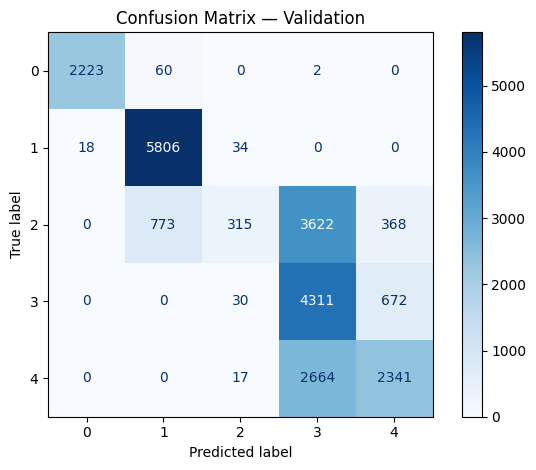

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



y_true, y_pred = [], []



with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        preds = model(x).argmax(dim=1).cpu()
        y_true.extend(y.numpy())
        y_pred.extend(preds.numpy())

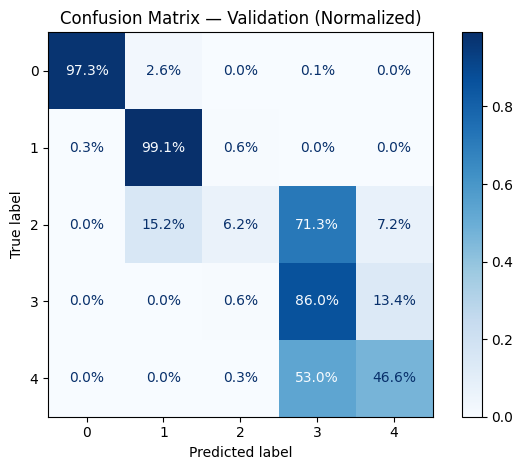

In [20]:
cm = confusion_matrix(y_true, y_pred, normalize='true')



disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='.1%')  # '.1%' formats as percentage with 1 decimal

plt.title("Confusion Matrix — Validation (Normalized)")
plt.tight_layout()
plt.show()


#### Classes 2 and 3 have a very close decision boundary. We need to focus a study on best finding this boundary.

In [3]:
import optuna
from sklearn.metrics import f1_score

# After each epoch a model is compared to the current best; if there is no chance it will outperform the best model, it's pruned
def objective(trial):

    cfg = {
      'lr': trial.suggest_categorical('lr', [0.01,0.001,0.005]),
      'dropout_prob': trial.suggest_categorical('dropout_prob', [0.1,0.2,0.3]),
      'fc_hidden': 128,
      'conv1_out': trial.suggest_categorical('conv1_out',[8,16]),
      'conv2_out': trial.suggest_categorical('conv2_out',[32,64]),
      'conv3_out': trial.suggest_categorical('conv3_out',[32,64,128]),
      'conv4_out': trial.suggest_categorical('conv4_out',[32,64,128]),
    }

    # Helper to build model, see setup
    model = build_model(cfg, 64, 96).to(device)

    # Adam optim
    opt = optim.Adam(model.parameters(), lr=cfg['lr'])

    # Weighted cross entropy loss (optional, still helps focus on harder classes)
    crit = nn.CrossEntropyLoss()

    for epoch in range(3):
        train_one_epoch(model, train_loader, opt, device)

        # Validation with predictions + labels
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                preds = torch.argmax(logits, dim=1)
                y_true.extend(yb.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        # compute mean F1 for classes 2,3,4 only
        f1_scores = f1_score(y_true, y_pred, average=None, labels=[0,1,2,3,4])
        f1_234 = f1_scores[2:5].mean()
        
        trial.report(f1_234, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return f1_234


# Create loaders
train_loader, val_loader = get_stratified_loaders(
    dataset,
    subset_frac=0.25,
    train_frac=0.8,
    batch_size=32,
    random_state=42
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Optuna study focusing on F1 for 2–4 speakers (This will best seperate the classes)
study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name='ConvCount_HPTune_F1_234'
)

# Only 50 trials - this should be extended in further work
study.optimize(objective, n_trials=50)

best_cfg = study.best_trial.params
print("Best HPs (optimised for 2-4 F1):", best_cfg)


[I 2025-08-18 14:53:20,781] A new study created in memory with name: ConvCount_HPTune_F1_234
Training: 100%|██████████| 727/727 [02:32<00:00,  4.78batch/s]
[I 2025-08-18 15:05:13,340] Trial 0 finished with value: 0.39188098597983295 and parameters: {'lr': 0.01, 'dropout_prob': 0.1, 'conv1_out': 16, 'conv2_out': 64, 'conv3_out': 128, 'conv4_out': 32}. Best is trial 0 with value: 0.39188098597983295.
Training: 100%|██████████| 727/727 [02:02<00:00,  5.96batch/s]
[I 2025-08-18 15:21:45,542] Trial 1 finished with value: 0.40185490272696933 and parameters: {'lr': 0.001, 'dropout_prob': 0.2, 'conv1_out': 16, 'conv2_out': 64, 'conv3_out': 128, 'conv4_out': 64}. Best is trial 1 with value: 0.40185490272696933.
Training: 100%|██████████| 727/727 [02:15<00:00,  5.37batch/s]
[I 2025-08-18 15:33:18,906] Trial 2 finished with value: 0.4261477345455331 and parameters: {'lr': 0.001, 'dropout_prob': 0.2, 'conv1_out': 16, 'conv2_out': 32, 'conv3_out': 128, 'conv4_out': 64}. Best is trial 2 with value: 

Best HPs (optimised for 2-4 F1): {'lr': 0.001, 'dropout_prob': 0.3, 'conv1_out': 8, 'conv2_out': 32, 'conv3_out': 128, 'conv4_out': 128}


In [4]:
# Model with config from Optuna study
final_model = ConvCount(
    conv1_out=best_cfg['conv1_out'],
    conv2_out=best_cfg['conv2_out'],
    conv3_out=best_cfg['conv3_out'],
    conv4_out=best_cfg['conv4_out'],
    fc_hidden=128,
    dropout_prob=best_cfg['dropout_prob']
)



# Adam optimizer
opt = optim.Adam(final_model.parameters(), lr=best_cfg['lr'])



# Cross Entropy loss
crit = nn.CrossEntropyLoss()



# Loaders
train_loader, val_loader = get_loaders(dataset)



# Train
for epoch in range(10):
    t0 = time()
    loss = train_one_epoch(final_model, train_loader, opt, device)  # tqdm is inside this
    dur = time() - t0
    print(f"Epoch {epoch+1} — Loss {loss:.4f} — {dur:.1f}s")



# Validate
val_acc = validate(final_model, val_loader, device)
print(f"Final val accuracy: {val_acc:.2%}")
torch.save(final_model.state_dict(), r"src/model/ConvCount_5_OptunaResults_F1_234.pt")

Training: 100%|██████████| 2907/2907 [34:42<00:00,  1.40batch/s]


Epoch 1 — Loss 0.7514 — 2082.0s


Training: 100%|██████████| 2907/2907 [38:31<00:00,  1.26batch/s]


Epoch 2 — Loss 0.6988 — 2311.2s


Training: 100%|██████████| 2907/2907 [35:37<00:00,  1.36batch/s]


Epoch 3 — Loss 0.6815 — 2137.9s


Training: 100%|██████████| 2907/2907 [35:14<00:00,  1.37batch/s]


Epoch 4 — Loss 0.6696 — 2114.5s


Training: 100%|██████████| 2907/2907 [39:18<00:00,  1.23batch/s]


Epoch 5 — Loss 0.6608 — 2358.4s


Training: 100%|██████████| 2907/2907 [38:46<00:00,  1.25batch/s]


Epoch 6 — Loss 0.6512 — 2326.2s


Training: 100%|██████████| 2907/2907 [36:57<00:00,  1.31batch/s]


Epoch 7 — Loss 0.6431 — 2217.4s


Training: 100%|██████████| 2907/2907 [34:22<00:00,  1.41batch/s]


Epoch 8 — Loss 0.6355 — 2062.1s


Training: 100%|██████████| 2907/2907 [39:52<00:00,  1.22batch/s]


Epoch 9 — Loss 0.6277 — 2392.4s


Training: 100%|██████████| 2907/2907 [38:30<00:00,  1.26batch/s]


Epoch 10 — Loss 0.6213 — 2310.1s
Final val accuracy: 65.94%


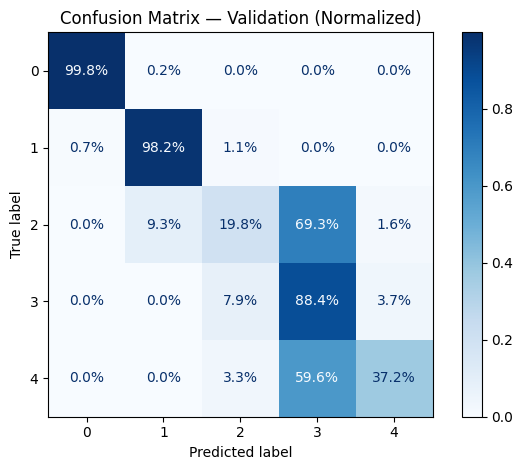

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true, y_pred = [], []


with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        preds = final_model(x).argmax(dim=1).cpu()
        y_true.extend(y.numpy())
        y_pred.extend(preds.numpy())

cm = confusion_matrix(y_true, y_pred, normalize='true')


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='.1%')  # '.1%' formats as percentage with 1 decimal

plt.title("Confusion Matrix — Validation (Normalized)")
plt.tight_layout()
plt.show()
